In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


In [2]:
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("Stock Adjusted Price Historical Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


In [3]:
# df_1 = multiple_stock_data(ticker=[['GOOGL','AAPL','AMZN']], start='09-19-2015',end='09-19-2018',plot=True, stock_value='Adj Close')
# df_1

In [4]:
def single_stock_data(symbol, start,end,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single

    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


## Forecasting
### Long Short Term Memory (LSTM)

Dataframe has 1331 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-21,31.622391,30.588236,31.404175,30.759012,24985175.0,25.028662
2015-09-22,30.673624,30.208729,30.341557,30.607210,25600290.0,24.905140
2015-09-23,31.129032,30.540796,30.569260,30.948767,27534696.0,25.183067
2015-09-24,31.195446,30.426945,30.702087,31.024668,32109161.0,25.244823
2015-09-25,31.404175,30.028463,31.271347,30.256166,36388296.0,24.619493
...,...,...,...,...,...,...
2020-12-24,37.570000,37.180000,37.400002,37.270000,14790100.0,36.868916
2020-12-28,37.580002,36.680000,37.360001,36.820000,26993700.0,36.423756
2020-12-29,37.200001,36.790001,36.900002,37.049999,23152100.0,36.651279


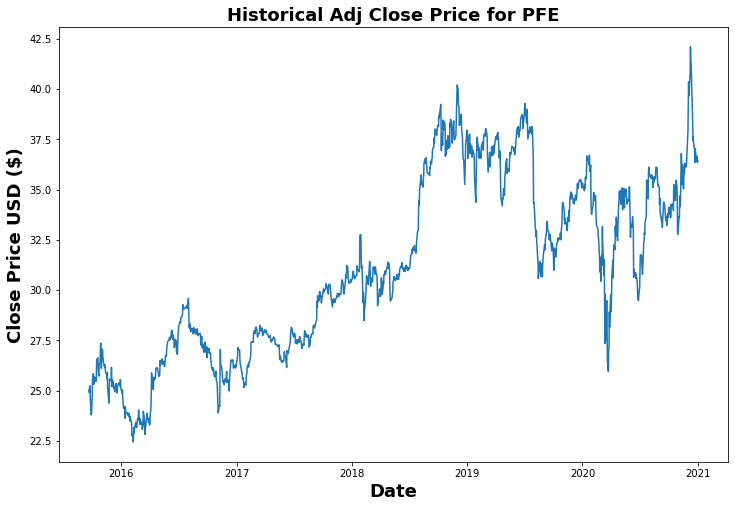

In [5]:
df = single_stock_data('PFE', start='09-19-2015',end='2021',plot=True,stock_value='Adj Close')
df

In [6]:
df_1 = df['Adj Close']
df_data = pd.DataFrame(df_1)#.values.astype('float32')

In [7]:
df_data

,Adj Close
Date,
2015-09-21,25.028662
2015-09-22,24.905140
2015-09-23,25.183067
2015-09-24,25.244823
2015-09-25,24.619493
...,...
2020-12-24,36.868916
2020-12-28,36.423756
2020-12-29,36.651279


In [54]:
(24.905140 / 25.028662) -1

-0.00493522186683415

In [8]:
# df_data = pd.read_csv('data/amzn.csv',usecols=[4]).values.astype('float32')
# df_data

In [9]:
def delta_time_series(data):
    data_1 = data.pct_change(1)
    data_1 = data_1.rename(columns={"Adj Close": "Percent_Chg"})
    #return data[1:]- data[:-1]
    data_1 = data_1.dropna()
    return data_1

In [10]:
dataset_delta_AMAZN = delta_time_series(df_data)
dataset_delta_AMAZN

,Percent_Chg
Date,
2015-09-22,-0.004935
2015-09-23,0.011159
2015-09-24,0.002452
2015-09-25,-0.024771
2015-09-28,-0.033553
...,...
2020-12-24,-0.004541
2020-12-28,-0.012074
2020-12-29,0.006247


In [11]:
#df_data.shape

In [57]:
def plot_delta(data,symbol=None):
    plt.figure(figsize=(12,6))
    plt.plot(delta_time_series(data))
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

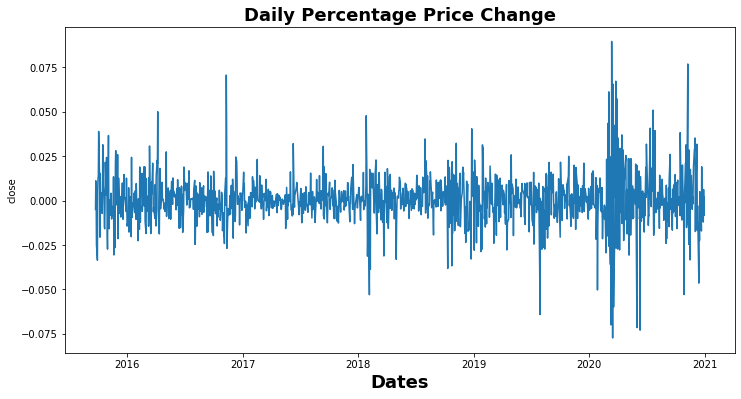

In [58]:
plot_delta(df_data)

In [14]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [15]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)

In [16]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_delta_AMAZN)
# split into train and test sets
train_size = int(len(dataset) * 0.80)#0.67
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [17]:
train.shape, test.shape, 

((1064, 1), (266, 1))

In [18]:
look_back = 3

In [19]:
train_data_gen = TimeseriesGenerator(train, train,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [20]:
test_data_gen = TimeseriesGenerator(test, test,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=1)

In [21]:
# model = Sequential()
# model.add(LSTM(4, input_shape=(look_back, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(look_back,1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=100,callbacks=[early_stop])

Epoch 1/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0115
Epoch 2/100
 15/354 [>.............................] - ETA: 2s - loss: 0.0039

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



354/354 [==============================] - 3s 8ms/step - loss: 0.0054
Epoch 3/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0052
Epoch 4/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0051
Epoch 5/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0049
Epoch 6/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0049
Epoch 7/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0049
Epoch 8/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0049
Epoch 9/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0048
Epoch 10/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0048
Epoch 11/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0049
Epoch 12/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0048
Epoch 13/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0049
Epoch 14/100
354/354 [==

354/354 [==============================] - 3s 8ms/step - loss: 0.0048


In [23]:
model.evaluate_generator(test_data_gen)

7.938146882224828e-05

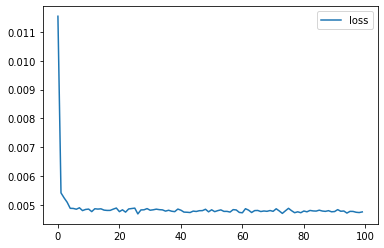

In [24]:
pd.DataFrame(hist.history).plot()

In [25]:
def save_model():
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [26]:
model_params = save_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [27]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

(1061, 1)

In [28]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(263, 1)

In [29]:
# invert predictions, scale values back to real index/price range.
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [30]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)


(1061, 1)
(263, 1)


In [31]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

(1061, 1)
(263, 1)


In [32]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.47 RMSE
Test Score: 0.48 RMSE


In [33]:
dataset = scaler.inverse_transform(dataset)
dataset.shape

(1330, 1)

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot + df_data[1:]
# set empty values
# trainPredictPlot[0:look_back, :] = np.nan
# trainPredictPlot[len(trainPredict)+look_back:, :] = np.nan


In [35]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot + df_data[1:]
# set empty values
# testPredictPlot[0:len(trainPredict)+(look_back*2), :] = np.nan
# testPredictPlot[len(dataset):, :] = np.nan

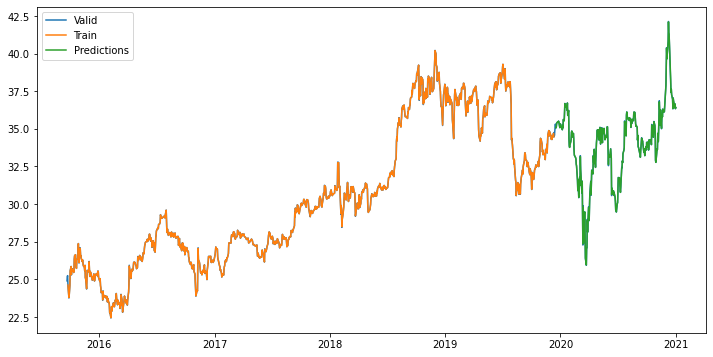

In [61]:
# plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(dataset + df_data[1:])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Valid','Train','Predictions'],loc='upper left')
#plt.show()


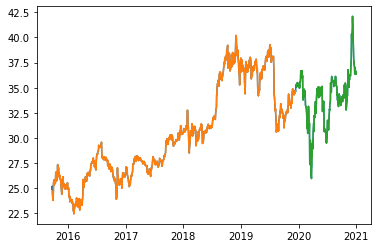

In [37]:
# plot baseline and predictions
plt.plot(dataset + df_data[:-1])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [42]:
# def get_quote(new_df):
#     #get last 60days closing values and convert datframe to an array
#     last_60_days = new_df[-60:].values #converts to array
#     #scale data
#     last_60_days_scaled = scaler.transform(last_60_days)
#     #create empty list
#     x_test = []
#     #append last 60 days to x_test
#     x_test.append(last_60_days_scaled)
#     #conert x_test to a numpy array
#     x_test = np.array(x_test)
#     # #reshape the data
#     x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#     #get the predicted scaled price
#     pred_price = model.predict(x_test)
#     #undo the scaling 
#     pred_price = scaler.inverse_transform(pred_price) 
#     #what model thinks predicted price will be for 12/18/2019
#     #the actual prcie was $69.94
#     #DAL: 58.58, 2021-1-11 40.19
#     return pred_price    

In [44]:
#get_quote(dataset)